# Temperature Effects on Photovoltaic Energy Yield

This notebook analyses the impact of photovoltaic cell temperature on daily and annual
energy yield for a fixed-tilt photovoltaic system in London.

We compare:
- An ideal photovoltaic model (no temperature losses)
- A temperature-adjusted photovoltaic model using the Nominal Operating Cell Temperature approach

Meteorological data is sourced from NASA POWER (daily resolution, 2023).


In [13]:
import sys
sys.path.append("..")

import pandas as pd
import matplotlib.pyplot as plt

from pv_model import (
    ideal_daily_photovoltaic_energy_output,
    pv_energy_temp_adjusted_daily
)

# -----------------------------
# System configuration
# -----------------------------
LATITUDE = 51.5        # London
TILT = 30              # degrees
CAPACITY_KWP = 4.0     # system size

DATA_PATH = "../data/weather_london_2023_cleaned.csv"


In [14]:
df = pd.read_csv(DATA_PATH)

df["date"] = pd.to_datetime(df["DATE"])
df["day_of_year"] = df["date"].dt.dayofyear

df = df.rename(columns={
    "ALLSKY_SFC_SW_DWN": "GHI",
    "T2M": "TEMP"
})

df.head()


,DATE,GHI,TEMP,date,day_of_year
0,2023-01-01,0.6343,9.18,2023-01-01,1
1,2023-01-02,1.0490,4.84,2023-01-02,2
2,2023-01-03,0.2347,7.70,2023-01-03,3
3,2023-01-04,0.6742,11.06,2023-01-04,4
4,2023-01-05,0.6101,9.94,2023-01-05,5


In [15]:
df["E_ideal"] = df.apply(
    lambda row: ideal_daily_photovoltaic_energy_output(
        ghi=row["GHI"],
        lat=LATITUDE,
        tilt=TILT,
        day_of_year=row["day_of_year"],
        capacity_kwp=CAPACITY_KWP
    ),
    axis=1
)

df["E_temp"] = df.apply(
    lambda row: pv_energy_temp_adjusted_daily(
        ghi=row["GHI"],
        temp_air=row["TEMP"],
        lat=LATITUDE,
        tilt=TILT,
        day_of_year=row["day_of_year"],
        capacity_kwp=CAPACITY_KWP
    ),
    axis=1
)

df[["date", "E_ideal", "E_temp"]].head()


,date,E_ideal,E_temp
0,2023-01-01,6.552974,6.743993
1,2023-01-02,10.793454,11.057075
2,2023-01-03,2.404385,2.540658
3,2023-01-04,6.874693,7.011873
4,2023-01-05,6.190286,6.363607


In [16]:
annual_ideal = df["E_ideal"].sum()
annual_temp = df["E_temp"].sum()

loss_kwh = annual_ideal - annual_temp
loss_pct = 100 * loss_kwh / annual_ideal

print(f"Ideal annual energy: {annual_ideal:.1f} kWh")
print(f"Temperature-adjusted annual energy: {annual_temp:.1f} kWh")
print(f"Annual energy loss due to temperature: {loss_kwh:.1f} kWh (-{loss_pct:.2f}%)")


Ideal annual energy: 5278.3 kWh
Temperature-adjusted annual energy: 5059.7 kWh
Annual energy loss due to temperature: 218.7 kWh (-4.14%)


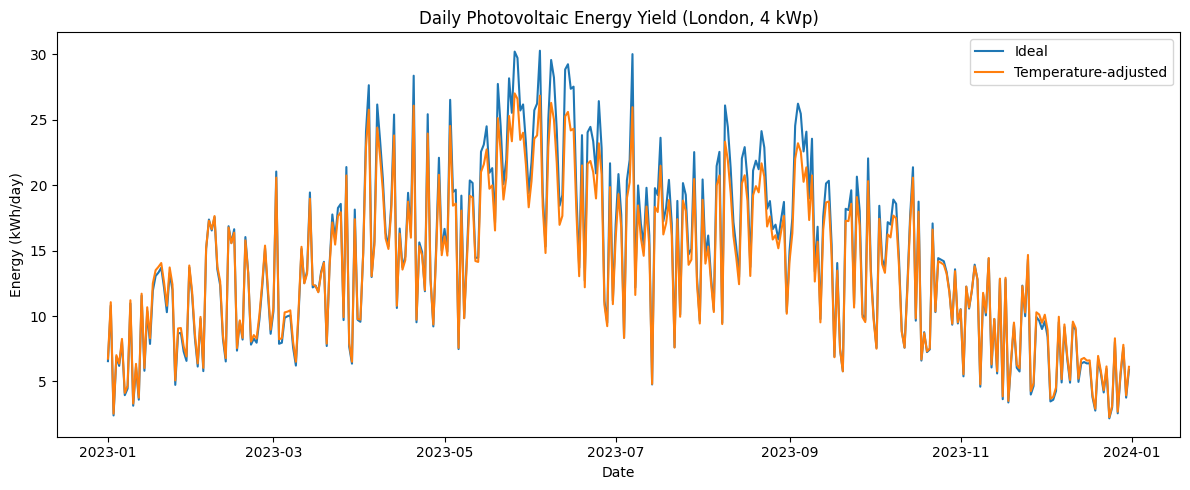

In [17]:
plt.figure(figsize=(12, 5))
plt.plot(df["date"], df["E_ideal"], label="Ideal")
plt.plot(df["date"], df["E_temp"], label="Temperature-adjusted")
plt.xlabel("Date")
plt.ylabel("Energy (kWh/day)")
plt.title("Daily Photovoltaic Energy Yield (London, 4 kWp)")
plt.legend()
plt.tight_layout()
plt.show()


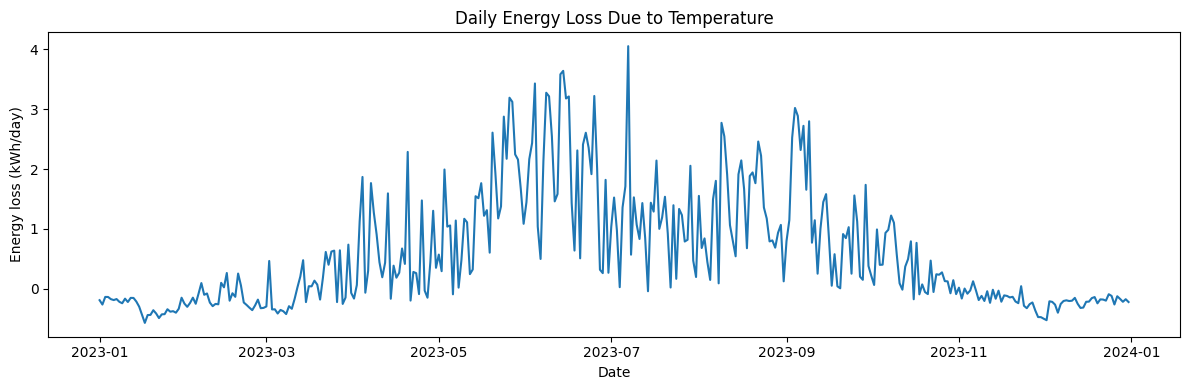

In [18]:
df["E_loss"] = df["E_ideal"] - df["E_temp"]

plt.figure(figsize=(12, 4))
plt.plot(df["date"], df["E_loss"])
plt.xlabel("Date")
plt.ylabel("Energy loss (kWh/day)")
plt.title("Daily Energy Loss Due to Temperature")
plt.tight_layout()
plt.show()


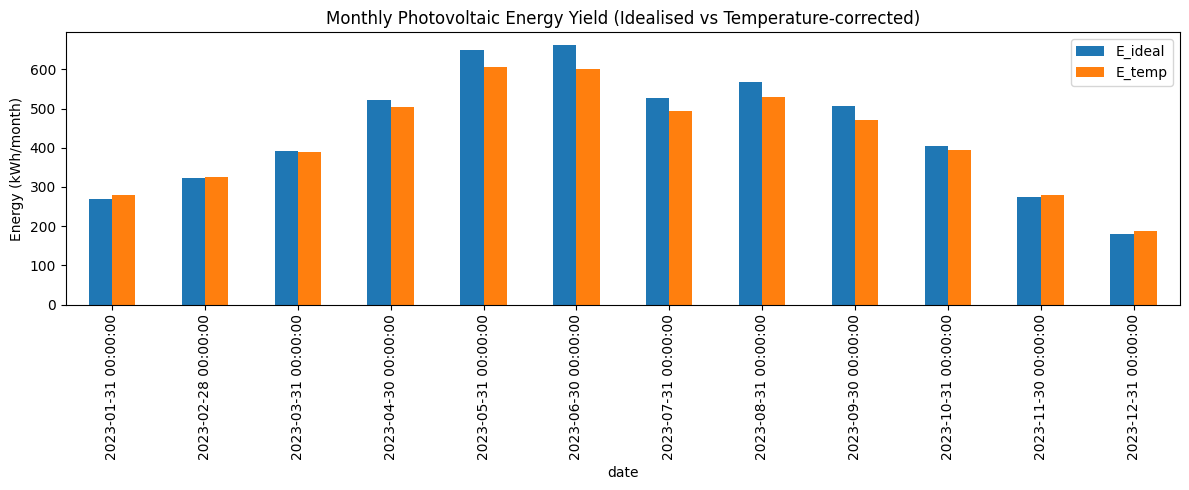

In [19]:
monthly = df.resample("ME", on="date")[["E_ideal", "E_temp"]].sum()

monthly.plot(kind="bar", figsize=(12, 5))
plt.ylabel("Energy (kWh/month)")
plt.title("Monthly Photovoltaic Energy Yield (Idealised vs Temperature-corrected)")
plt.tight_layout()
plt.show()


## Results

### Annual Energy Yield

For a fixed-tilt photovoltaic system in London (latitude 51.5°) with a nominal
capacity of 4 kWp, the model predicts an annual energy yield of:

- **Ideal (25 °C reference): 5278.3 kWh**
- **Temperature-adjusted: 5059.7 kWh**

This corresponds to an annual energy reduction of approximately **4.14%**
(218.7 kWh) due to temperature effects.

---

### Seasonal Behaviour

Daily energy yield follows a smooth seasonal pattern, with peak production
occurring in late spring and early summer. The impact of temperature on PV
output is strongly seasonal:

- During winter months, the temperature-adjusted model slightly exceeds the
  ideal model, as low ambient temperatures improve photovoltaic conversion efficiency.
- During summer months, higher irradiance leads to elevated cell temperatures,
  reducing photovoltaic efficiency and resulting in noticeable energy losses.

Although winter days exhibit efficiency gains, summer losses dominate on an
annual basis, leading to a net reduction in energy yield.

---

### Temperature Loss Characteristics

Daily energy losses due to temperature peak during periods of high irradiance,
rather than during periods of highest ambient temperature alone. This reflects
the combined influence of solar irradiance and thermal effects on photovoltaic cell
temperature.

The results demonstrate that temperature losses primarily affect periods of
maximum solar availability, reinforcing the importance of accounting for thermal
effects when estimating realistic photovoltaic system performance.

---

### Model Limitations

This analysis is based on daily-averaged meteorological data and a simplified
NOCT-based cell temperature model. Instantaneous effects, wind speed, and
thermal inertia are not explicitly represented. Despite these simplifications,
the model captures the dominant first-order temperature effects on annual photovoltaic
energy yield.
